<a href="https://colab.research.google.com/github/Gracia123/Sales-Prediction/blob/main/CS680_A6_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...



Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Neural Network class

* Generator
* Discriminator


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        # dummy assignment until this function is filled in
        #self.fc1 = nn.Linear(1, 1)
        self.fc1 = nn.Linear(400, 784)
        #self.fc2 = nn.Linear(400, 20)
        self.fc2 = nn.Linear(20, 400)
        #self.fc4 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):

        # dummy assignment until this function is filled in
        h = F.relu(self.fc2(z))
        probabilities = torch.sigmoid(self.fc1(h))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        # dummy assignment until this function is filled in
        self.fc1 = nn.Linear(784, 400)
        self.fc2=nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):

        # dummy assignment until this function is filled in
        h = F.relu(self.fc1(x.view(-1, 784)))
        probabilities = torch.sigmoid(self.fc2(h))
        return probabilities

# Loss Function

In [ ]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):

    # dummy assignment until this function is filled in
    #BCE = 0
    #BCE = F.binary_cross_entropy(predictions, targets.view(-1), reduction='sum')
    BCE = BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [ ]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    train_generator_loss = 0
    train_discriminator_loss = 0
    real_label = 1
    fake_label = 0
    loss_real_train = 0
    loss_fake_train = 0
    for batch_idx, (data, _) in enumerate(train_loader):
      data = data.to(device)
      discriminator.zero_grad()
      b_size = data.size()[0]
      label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
      label = label.unsqueeze(1)
      # Forward pass real batch through D
      output = discriminator(data)
      # Calculate loss on all-real batch
      real_loss_discriminator = gan_loss_function(output, label) 
      # Calculate gradients for D in backward pass
      real_loss_discriminator.backward()
      #loss_real_train = real_loss_discriminator.item() 

      ## Train with all-fake batch
      # Generate batch of latent vectors
      noise = torch.randn(data.size()[0],20).to(device) 
      # Generate fake image batch with G
      fake = generator(noise)
      label.fill_(fake_label)
      # Classify all fake batch with D
      output = discriminator(fake.detach()).view(-1)
      output = output.unsqueeze(1)
      # Calculate D's loss on the all-fake batch
      fake_loss_discriminator = gan_loss_function(output, label) #predictions, targets
      # Calculate the gradients for this batch
      fake_loss_discriminator.backward()
      #loss_fake_train = fake_loss_discriminator.item()

      # Add the gradients from the all-real and all-fake batches
      discriminator_loss = real_loss_discriminator + fake_loss_discriminator
      train_discriminator_loss += discriminator_loss.item()
      # Update D
      discriminator_optimizer.step()

      generator.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      output = discriminator(fake).view(-1)
      output = output.unsqueeze(1)
      # Calculate G's loss based on this output
      generator_loss = gan_loss_function(output, label) 
      # Calculate gradients for G
      generator_loss.backward()
      train_generator_loss += generator_loss.item()
      # Update G
      generator_optimizer.step()


      if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                100. *discriminator_loss.item() / len(data),
                100. *generator_loss.item() / len(data)))  


    # dummy assignment until this function is filled in
    average_discriminator_loss = 100. *train_discriminator_loss / len(train_loader.dataset)
    average_generator_loss = 100. *train_generator_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_discriminator_loss, average_generator_loss))  
    return average_generator_loss, average_discriminator_loss


# Testing


In [ ]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):
    discriminator.eval()
    generator.eval()
    test_generator_loss = 0
    test_discriminator_loss = 0
    real_label = 1
    fake_label = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
          data = data.to(device)
          b_size = data.size()[0]
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          
          # Forward pass real batch through D
          output = discriminator(data).view(-1)
          # Calculate loss on all-real batch
          discriminator_real_loss = gan_loss_function(output, label) #predictions, targets
          # d_loss_real += discriminator_real_loss.item()

          ## test with all-fake batch
          # Generate batch of latent vectors
          noise = torch.randn(data.size()[0],20).to(device)
          # Generate fake image batch with G
          fake = generator(noise)
          label.fill_(fake_label)
          # Classify all fake batch with D
          output = discriminator(fake.detach()).view(-1)
          # Calculate D's loss on the all-fake batch
          discriminator_fake_loss = gan_loss_function(output, label) #predictions, targets
          #d_loss_fake += discriminator_fake_loss.item()
          # Add the gradients from the all-real and all-fake batches
          discriminator_loss = discriminator_real_loss + discriminator_fake_loss
          test_discriminator_loss += discriminator_loss.item()

          label.fill_(real_label)  # fake labels are real for generator cost
          output = discriminator(fake).view(-1)
          # Calculate G's loss based on this output
          generator_loss = gan_loss_function(output, label) #predictions, targets
          test_generator_loss += generator_loss.item()

    average_discriminator_loss = 100. * test_discriminator_loss / len(test_loader.dataset)
    average_generator_loss = 100. * test_generator_loss / len(test_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, average_discriminator_loss, average_generator_loss))

    return average_generator_loss, average_discriminator_loss

# Main

Train Epoch: 1 [0/60000 (0%)]	Loss: 135.727596
Train Epoch: 1 [12800/60000 (21%)]	Loss: 15.768072
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.030249
Train Epoch: 1 [38400/60000 (64%)]	Loss: 16.339839
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.413884
====> Epoch: 1 Average loss: 14.6293
====> Epoch: 1 Average loss: 5.3079
Sample of generated images


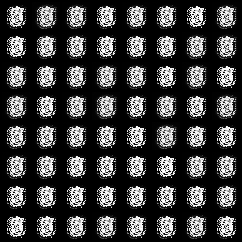



Train Epoch: 2 [0/60000 (0%)]	Loss: 7.389772
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.588369
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.892476
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.636798
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.725482
====> Epoch: 2 Average loss: 1.9883
====> Epoch: 2 Average loss: 1.0638
Sample of generated images


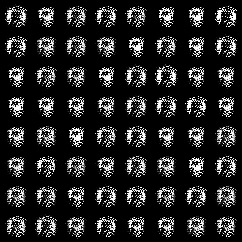



Train Epoch: 3 [0/60000 (0%)]	Loss: 0.638356
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.718198
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.337330
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.856434
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.055851
====> Epoch: 3 Average loss: 1.4570
====> Epoch: 3 Average loss: 1.0115
Sample of generated images


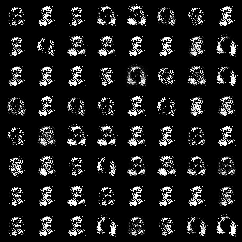



Train Epoch: 4 [0/60000 (0%)]	Loss: 1.116809
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.454818
Train Epoch: 4 [25600/60000 (43%)]	Loss: 3.566676
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.703411
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.952910
====> Epoch: 4 Average loss: 1.7660
====> Epoch: 4 Average loss: 0.9960
Sample of generated images


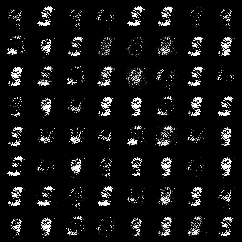



Train Epoch: 5 [0/60000 (0%)]	Loss: 0.926601
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.994799
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.031903
Train Epoch: 5 [38400/60000 (64%)]	Loss: 1.537353
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.309023
====> Epoch: 5 Average loss: 2.2885
====> Epoch: 5 Average loss: 2.6716
Sample of generated images


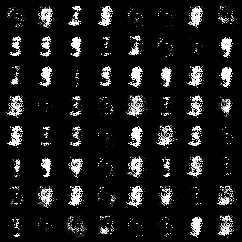



Train Epoch: 6 [0/60000 (0%)]	Loss: 1.923465
Train Epoch: 6 [12800/60000 (21%)]	Loss: 3.642388
Train Epoch: 6 [25600/60000 (43%)]	Loss: 3.641927
Train Epoch: 6 [38400/60000 (64%)]	Loss: 4.170232
Train Epoch: 6 [51200/60000 (85%)]	Loss: 3.870086
====> Epoch: 6 Average loss: 4.0558
====> Epoch: 6 Average loss: 5.2496
Sample of generated images


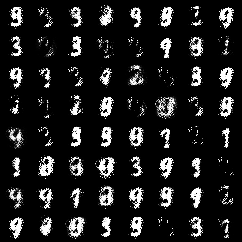



Train Epoch: 7 [0/60000 (0%)]	Loss: 3.376059
Train Epoch: 7 [12800/60000 (21%)]	Loss: 7.697155
Train Epoch: 7 [25600/60000 (43%)]	Loss: 5.847855
Train Epoch: 7 [38400/60000 (64%)]	Loss: 6.748563
Train Epoch: 7 [51200/60000 (85%)]	Loss: 4.054683
====> Epoch: 7 Average loss: 6.0018
====> Epoch: 7 Average loss: 6.3254
Sample of generated images


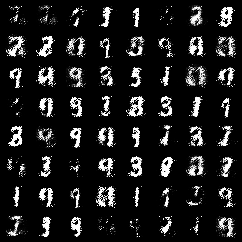



Train Epoch: 8 [0/60000 (0%)]	Loss: 3.310211
Train Epoch: 8 [12800/60000 (21%)]	Loss: 4.771189
Train Epoch: 8 [25600/60000 (43%)]	Loss: 5.441273
Train Epoch: 8 [38400/60000 (64%)]	Loss: 9.561989
Train Epoch: 8 [51200/60000 (85%)]	Loss: 7.505843
====> Epoch: 8 Average loss: 8.1444
====> Epoch: 8 Average loss: 7.8120
Sample of generated images


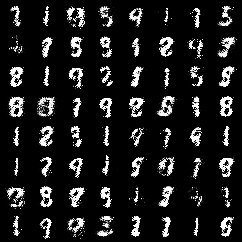



Train Epoch: 9 [0/60000 (0%)]	Loss: 6.263244
Train Epoch: 9 [12800/60000 (21%)]	Loss: 9.858329
Train Epoch: 9 [25600/60000 (43%)]	Loss: 13.404629
Train Epoch: 9 [38400/60000 (64%)]	Loss: 14.327018
Train Epoch: 9 [51200/60000 (85%)]	Loss: 7.040504
====> Epoch: 9 Average loss: 8.7966
====> Epoch: 9 Average loss: 12.8302
Sample of generated images


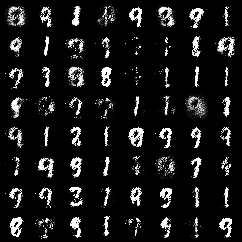



Train Epoch: 10 [0/60000 (0%)]	Loss: 14.771082
Train Epoch: 10 [12800/60000 (21%)]	Loss: 9.363572
Train Epoch: 10 [25600/60000 (43%)]	Loss: 14.006150
Train Epoch: 10 [38400/60000 (64%)]	Loss: 9.842964
Train Epoch: 10 [51200/60000 (85%)]	Loss: 11.861459
====> Epoch: 10 Average loss: 11.5185
====> Epoch: 10 Average loss: 14.5240
Sample of generated images


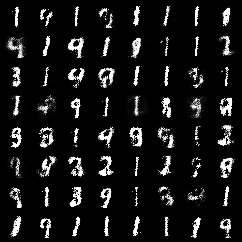



Train Epoch: 11 [0/60000 (0%)]	Loss: 9.411659
Train Epoch: 11 [12800/60000 (21%)]	Loss: 10.279738
Train Epoch: 11 [25600/60000 (43%)]	Loss: 12.768139
Train Epoch: 11 [38400/60000 (64%)]	Loss: 17.567649
Train Epoch: 11 [51200/60000 (85%)]	Loss: 20.182753
====> Epoch: 11 Average loss: 15.5196
====> Epoch: 11 Average loss: 19.5490
Sample of generated images


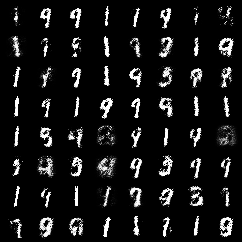



Train Epoch: 12 [0/60000 (0%)]	Loss: 23.484209
Train Epoch: 12 [12800/60000 (21%)]	Loss: 19.299702
Train Epoch: 12 [25600/60000 (43%)]	Loss: 22.173268
Train Epoch: 12 [38400/60000 (64%)]	Loss: 19.612333
Train Epoch: 12 [51200/60000 (85%)]	Loss: 14.222717
====> Epoch: 12 Average loss: 18.6486
====> Epoch: 12 Average loss: 33.7692
Sample of generated images


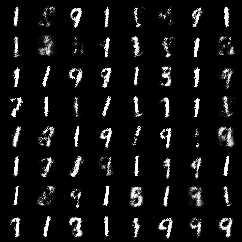



Train Epoch: 13 [0/60000 (0%)]	Loss: 34.281278
Train Epoch: 13 [12800/60000 (21%)]	Loss: 21.853045
Train Epoch: 13 [25600/60000 (43%)]	Loss: 16.317123
Train Epoch: 13 [38400/60000 (64%)]	Loss: 19.236961
Train Epoch: 13 [51200/60000 (85%)]	Loss: 24.116364
====> Epoch: 13 Average loss: 23.4797
====> Epoch: 13 Average loss: 31.5242
Sample of generated images


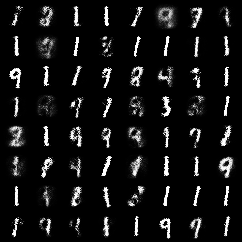



Train Epoch: 14 [0/60000 (0%)]	Loss: 26.500240
Train Epoch: 14 [12800/60000 (21%)]	Loss: 28.298917
Train Epoch: 14 [25600/60000 (43%)]	Loss: 36.540052
Train Epoch: 14 [38400/60000 (64%)]	Loss: 24.959998
Train Epoch: 14 [51200/60000 (85%)]	Loss: 32.214940
====> Epoch: 14 Average loss: 28.4285
====> Epoch: 14 Average loss: 32.4712
Sample of generated images


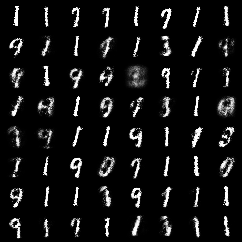



Train Epoch: 15 [0/60000 (0%)]	Loss: 26.231015
Train Epoch: 15 [12800/60000 (21%)]	Loss: 22.573577
Train Epoch: 15 [25600/60000 (43%)]	Loss: 42.827231
Train Epoch: 15 [38400/60000 (64%)]	Loss: 22.683059
Train Epoch: 15 [51200/60000 (85%)]	Loss: 39.867118
====> Epoch: 15 Average loss: 32.5109
====> Epoch: 15 Average loss: 33.2515
Sample of generated images


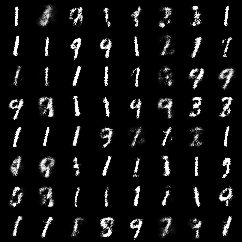



Train Epoch: 16 [0/60000 (0%)]	Loss: 34.572691
Train Epoch: 16 [12800/60000 (21%)]	Loss: 39.447355
Train Epoch: 16 [25600/60000 (43%)]	Loss: 40.338308
Train Epoch: 16 [38400/60000 (64%)]	Loss: 46.720728
Train Epoch: 16 [51200/60000 (85%)]	Loss: 26.314667
====> Epoch: 16 Average loss: 35.5057
====> Epoch: 16 Average loss: 44.2623
Sample of generated images


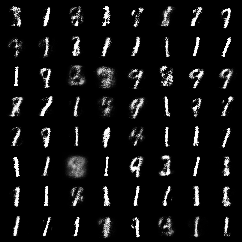



Train Epoch: 17 [0/60000 (0%)]	Loss: 44.206938
Train Epoch: 17 [12800/60000 (21%)]	Loss: 31.659484
Train Epoch: 17 [25600/60000 (43%)]	Loss: 41.094732
Train Epoch: 17 [38400/60000 (64%)]	Loss: 36.360997
Train Epoch: 17 [51200/60000 (85%)]	Loss: 38.642263
====> Epoch: 17 Average loss: 39.2122
====> Epoch: 17 Average loss: 49.5519
Sample of generated images


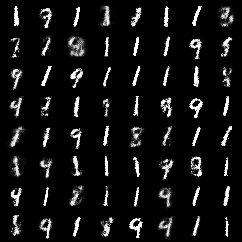



Train Epoch: 18 [0/60000 (0%)]	Loss: 39.311758
Train Epoch: 18 [12800/60000 (21%)]	Loss: 55.146003
Train Epoch: 18 [25600/60000 (43%)]	Loss: 37.039453
Train Epoch: 18 [38400/60000 (64%)]	Loss: 36.374080
Train Epoch: 18 [51200/60000 (85%)]	Loss: 46.546870
====> Epoch: 18 Average loss: 40.3014
====> Epoch: 18 Average loss: 45.3321
Sample of generated images


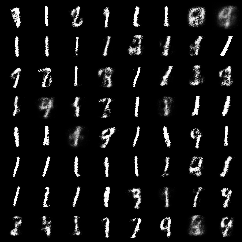



Train Epoch: 19 [0/60000 (0%)]	Loss: 46.235704
Train Epoch: 19 [12800/60000 (21%)]	Loss: 55.167747
Train Epoch: 19 [25600/60000 (43%)]	Loss: 47.195998
Train Epoch: 19 [38400/60000 (64%)]	Loss: 56.922901
Train Epoch: 19 [51200/60000 (85%)]	Loss: 60.617685
====> Epoch: 19 Average loss: 43.7993
====> Epoch: 19 Average loss: 53.8848
Sample of generated images


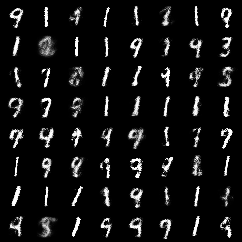



Train Epoch: 20 [0/60000 (0%)]	Loss: 51.565897
Train Epoch: 20 [12800/60000 (21%)]	Loss: 47.398093
Train Epoch: 20 [25600/60000 (43%)]	Loss: 57.407343
Train Epoch: 20 [38400/60000 (64%)]	Loss: 45.933563
Train Epoch: 20 [51200/60000 (85%)]	Loss: 33.338779
====> Epoch: 20 Average loss: 45.2967
====> Epoch: 20 Average loss: 56.4072
Sample of generated images


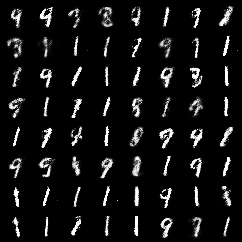



Train Epoch: 21 [0/60000 (0%)]	Loss: 39.612773
Train Epoch: 21 [12800/60000 (21%)]	Loss: 47.461480
Train Epoch: 21 [25600/60000 (43%)]	Loss: 53.870088
Train Epoch: 21 [38400/60000 (64%)]	Loss: 32.146198
Train Epoch: 21 [51200/60000 (85%)]	Loss: 66.994226
====> Epoch: 21 Average loss: 47.6658
====> Epoch: 21 Average loss: 63.5214
Sample of generated images


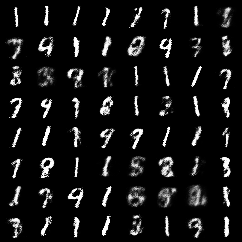



Train Epoch: 22 [0/60000 (0%)]	Loss: 58.123469
Train Epoch: 22 [12800/60000 (21%)]	Loss: 45.255604
Train Epoch: 22 [25600/60000 (43%)]	Loss: 26.017499
Train Epoch: 22 [38400/60000 (64%)]	Loss: 37.533757
Train Epoch: 22 [51200/60000 (85%)]	Loss: 49.081311
====> Epoch: 22 Average loss: 49.8002
====> Epoch: 22 Average loss: 74.2082
Sample of generated images


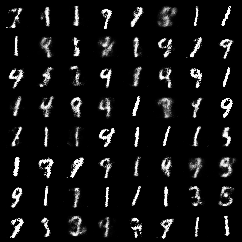



Train Epoch: 23 [0/60000 (0%)]	Loss: 71.008420
Train Epoch: 23 [12800/60000 (21%)]	Loss: 57.284200
Train Epoch: 23 [25600/60000 (43%)]	Loss: 35.314423
Train Epoch: 23 [38400/60000 (64%)]	Loss: 58.867562
Train Epoch: 23 [51200/60000 (85%)]	Loss: 49.266273
====> Epoch: 23 Average loss: 50.1747
====> Epoch: 23 Average loss: 72.5731
Sample of generated images


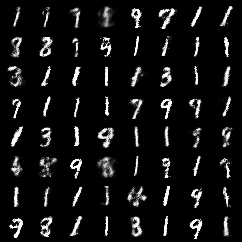



Train Epoch: 24 [0/60000 (0%)]	Loss: 71.146715
Train Epoch: 24 [12800/60000 (21%)]	Loss: 57.001156
Train Epoch: 24 [25600/60000 (43%)]	Loss: 49.990115
Train Epoch: 24 [38400/60000 (64%)]	Loss: 43.681866
Train Epoch: 24 [51200/60000 (85%)]	Loss: 66.990042
====> Epoch: 24 Average loss: 53.1300
====> Epoch: 24 Average loss: 49.4249
Sample of generated images


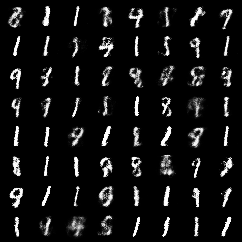



Train Epoch: 25 [0/60000 (0%)]	Loss: 36.545426
Train Epoch: 25 [12800/60000 (21%)]	Loss: 62.966299
Train Epoch: 25 [25600/60000 (43%)]	Loss: 42.107815
Train Epoch: 25 [38400/60000 (64%)]	Loss: 61.145753
Train Epoch: 25 [51200/60000 (85%)]	Loss: 58.030796
====> Epoch: 25 Average loss: 52.3635
====> Epoch: 25 Average loss: 62.2524
Sample of generated images


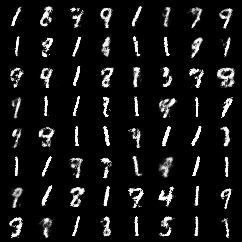



Train Epoch: 26 [0/60000 (0%)]	Loss: 53.572720
Train Epoch: 26 [12800/60000 (21%)]	Loss: 53.704244
Train Epoch: 26 [25600/60000 (43%)]	Loss: 49.293107
Train Epoch: 26 [38400/60000 (64%)]	Loss: 39.754862
Train Epoch: 26 [51200/60000 (85%)]	Loss: 36.897716
====> Epoch: 26 Average loss: 52.4123
====> Epoch: 26 Average loss: 51.9633
Sample of generated images


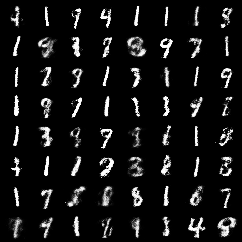



Train Epoch: 27 [0/60000 (0%)]	Loss: 48.147097
Train Epoch: 27 [12800/60000 (21%)]	Loss: 54.607677
Train Epoch: 27 [25600/60000 (43%)]	Loss: 45.673746
Train Epoch: 27 [38400/60000 (64%)]	Loss: 44.519770
Train Epoch: 27 [51200/60000 (85%)]	Loss: 53.784621
====> Epoch: 27 Average loss: 54.1027
====> Epoch: 27 Average loss: 59.5712
Sample of generated images


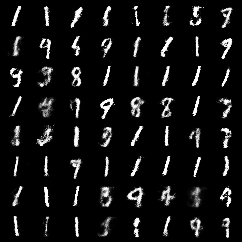



Train Epoch: 28 [0/60000 (0%)]	Loss: 69.757468
Train Epoch: 28 [12800/60000 (21%)]	Loss: 49.775344
Train Epoch: 28 [25600/60000 (43%)]	Loss: 49.475262
Train Epoch: 28 [38400/60000 (64%)]	Loss: 45.996249
Train Epoch: 28 [51200/60000 (85%)]	Loss: 64.880204
====> Epoch: 28 Average loss: 54.9439
====> Epoch: 28 Average loss: 60.4453
Sample of generated images


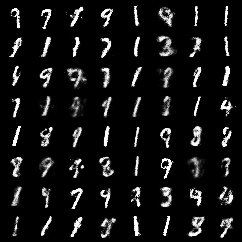



Train Epoch: 29 [0/60000 (0%)]	Loss: 67.115492
Train Epoch: 29 [12800/60000 (21%)]	Loss: 71.922630
Train Epoch: 29 [25600/60000 (43%)]	Loss: 70.459437
Train Epoch: 29 [38400/60000 (64%)]	Loss: 47.536933
Train Epoch: 29 [51200/60000 (85%)]	Loss: 55.954081
====> Epoch: 29 Average loss: 55.2881
====> Epoch: 29 Average loss: 51.3940
Sample of generated images


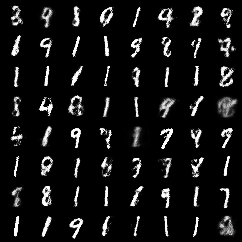



Train Epoch: 30 [0/60000 (0%)]	Loss: 38.711989
Train Epoch: 30 [12800/60000 (21%)]	Loss: 34.504449
Train Epoch: 30 [25600/60000 (43%)]	Loss: 58.582735
Train Epoch: 30 [38400/60000 (64%)]	Loss: 60.613143
Train Epoch: 30 [51200/60000 (85%)]	Loss: 61.317110
====> Epoch: 30 Average loss: 55.3325
====> Epoch: 30 Average loss: 69.9037
Sample of generated images


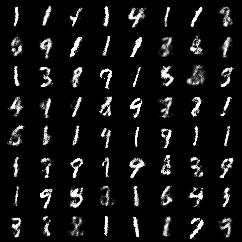



Train Epoch: 31 [0/60000 (0%)]	Loss: 67.322385
Train Epoch: 31 [12800/60000 (21%)]	Loss: 73.528135
Train Epoch: 31 [25600/60000 (43%)]	Loss: 61.595351
Train Epoch: 31 [38400/60000 (64%)]	Loss: 54.947269
Train Epoch: 31 [51200/60000 (85%)]	Loss: 47.731102
====> Epoch: 31 Average loss: 56.7636
====> Epoch: 31 Average loss: 59.3301
Sample of generated images


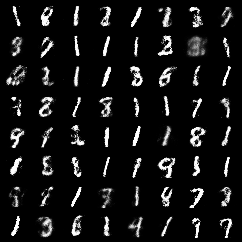



Train Epoch: 32 [0/60000 (0%)]	Loss: 45.496082
Train Epoch: 32 [12800/60000 (21%)]	Loss: 72.267640
Train Epoch: 32 [25600/60000 (43%)]	Loss: 53.598166
Train Epoch: 32 [38400/60000 (64%)]	Loss: 49.848241
Train Epoch: 32 [51200/60000 (85%)]	Loss: 47.176856
====> Epoch: 32 Average loss: 56.0928
====> Epoch: 32 Average loss: 64.6001
Sample of generated images


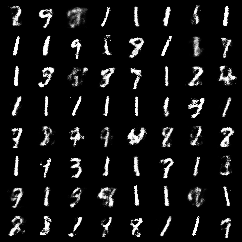



Train Epoch: 33 [0/60000 (0%)]	Loss: 59.958744
Train Epoch: 33 [12800/60000 (21%)]	Loss: 49.506155
Train Epoch: 33 [25600/60000 (43%)]	Loss: 65.273154
Train Epoch: 33 [38400/60000 (64%)]	Loss: 61.401045
Train Epoch: 33 [51200/60000 (85%)]	Loss: 62.562656
====> Epoch: 33 Average loss: 55.3728
====> Epoch: 33 Average loss: 62.9896
Sample of generated images


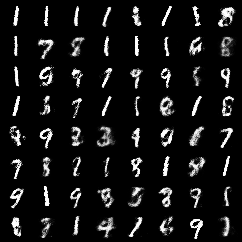



Train Epoch: 34 [0/60000 (0%)]	Loss: 59.314716
Train Epoch: 34 [12800/60000 (21%)]	Loss: 52.486742
Train Epoch: 34 [25600/60000 (43%)]	Loss: 59.925497
Train Epoch: 34 [38400/60000 (64%)]	Loss: 51.655674
Train Epoch: 34 [51200/60000 (85%)]	Loss: 63.753396
====> Epoch: 34 Average loss: 55.3536
====> Epoch: 34 Average loss: 51.9538
Sample of generated images


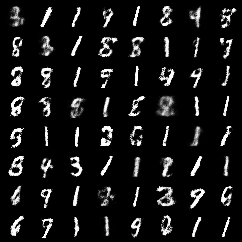



Train Epoch: 35 [0/60000 (0%)]	Loss: 52.966744
Train Epoch: 35 [12800/60000 (21%)]	Loss: 61.400479
Train Epoch: 35 [25600/60000 (43%)]	Loss: 49.271199
Train Epoch: 35 [38400/60000 (64%)]	Loss: 65.968585
Train Epoch: 35 [51200/60000 (85%)]	Loss: 69.663250
====> Epoch: 35 Average loss: 56.4592
====> Epoch: 35 Average loss: 69.1238
Sample of generated images


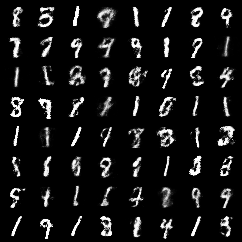



Train Epoch: 36 [0/60000 (0%)]	Loss: 70.800954
Train Epoch: 36 [12800/60000 (21%)]	Loss: 58.873761
Train Epoch: 36 [25600/60000 (43%)]	Loss: 50.087988
Train Epoch: 36 [38400/60000 (64%)]	Loss: 54.282486
Train Epoch: 36 [51200/60000 (85%)]	Loss: 60.929656
====> Epoch: 36 Average loss: 55.9458
====> Epoch: 36 Average loss: 60.2690
Sample of generated images


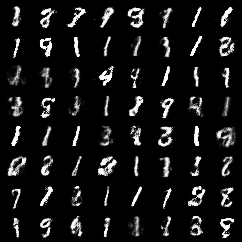



Train Epoch: 37 [0/60000 (0%)]	Loss: 64.675796
Train Epoch: 37 [12800/60000 (21%)]	Loss: 86.154795
Train Epoch: 37 [25600/60000 (43%)]	Loss: 43.518719
Train Epoch: 37 [38400/60000 (64%)]	Loss: 43.350944
Train Epoch: 37 [51200/60000 (85%)]	Loss: 49.480200
====> Epoch: 37 Average loss: 56.5772
====> Epoch: 37 Average loss: 61.7529
Sample of generated images


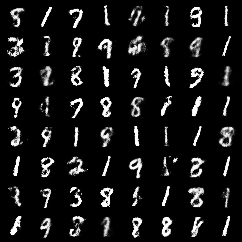



Train Epoch: 38 [0/60000 (0%)]	Loss: 57.167232
Train Epoch: 38 [12800/60000 (21%)]	Loss: 48.801586
Train Epoch: 38 [25600/60000 (43%)]	Loss: 55.789107
Train Epoch: 38 [38400/60000 (64%)]	Loss: 53.500539
Train Epoch: 38 [51200/60000 (85%)]	Loss: 65.670037
====> Epoch: 38 Average loss: 56.2180
====> Epoch: 38 Average loss: 61.0599
Sample of generated images


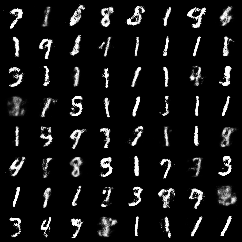



Train Epoch: 39 [0/60000 (0%)]	Loss: 64.276683
Train Epoch: 39 [12800/60000 (21%)]	Loss: 46.718168
Train Epoch: 39 [25600/60000 (43%)]	Loss: 67.744356
Train Epoch: 39 [38400/60000 (64%)]	Loss: 60.205138
Train Epoch: 39 [51200/60000 (85%)]	Loss: 43.764287
====> Epoch: 39 Average loss: 56.7860
====> Epoch: 39 Average loss: 62.5598
Sample of generated images


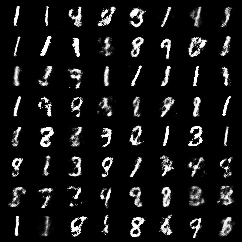



Train Epoch: 40 [0/60000 (0%)]	Loss: 44.696993
Train Epoch: 40 [12800/60000 (21%)]	Loss: 46.373439
Train Epoch: 40 [25600/60000 (43%)]	Loss: 54.686689
Train Epoch: 40 [38400/60000 (64%)]	Loss: 61.161655
Train Epoch: 40 [51200/60000 (85%)]	Loss: 60.364282
====> Epoch: 40 Average loss: 57.4452
====> Epoch: 40 Average loss: 68.1197
Sample of generated images


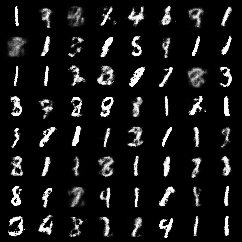



Train Epoch: 41 [0/60000 (0%)]	Loss: 59.292924
Train Epoch: 41 [12800/60000 (21%)]	Loss: 57.984579
Train Epoch: 41 [25600/60000 (43%)]	Loss: 56.973785
Train Epoch: 41 [38400/60000 (64%)]	Loss: 51.302636
Train Epoch: 41 [51200/60000 (85%)]	Loss: 52.300787
====> Epoch: 41 Average loss: 57.7293
====> Epoch: 41 Average loss: 70.5273
Sample of generated images


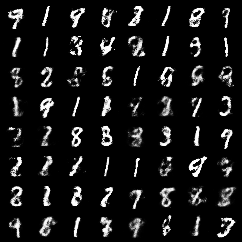



Train Epoch: 42 [0/60000 (0%)]	Loss: 62.999177
Train Epoch: 42 [12800/60000 (21%)]	Loss: 52.662593
Train Epoch: 42 [25600/60000 (43%)]	Loss: 53.497183
Train Epoch: 42 [38400/60000 (64%)]	Loss: 61.924160
Train Epoch: 42 [51200/60000 (85%)]	Loss: 43.012559
====> Epoch: 42 Average loss: 57.9219
====> Epoch: 42 Average loss: 63.0183
Sample of generated images


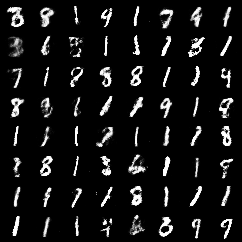



Train Epoch: 43 [0/60000 (0%)]	Loss: 61.055911
Train Epoch: 43 [12800/60000 (21%)]	Loss: 62.485170
Train Epoch: 43 [25600/60000 (43%)]	Loss: 55.809057
Train Epoch: 43 [38400/60000 (64%)]	Loss: 66.253245
Train Epoch: 43 [51200/60000 (85%)]	Loss: 58.215332
====> Epoch: 43 Average loss: 57.1799
====> Epoch: 43 Average loss: 58.1503
Sample of generated images


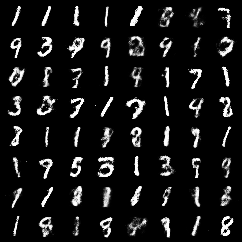



Train Epoch: 44 [0/60000 (0%)]	Loss: 40.586537
Train Epoch: 44 [12800/60000 (21%)]	Loss: 49.530467
Train Epoch: 44 [25600/60000 (43%)]	Loss: 53.486192
Train Epoch: 44 [38400/60000 (64%)]	Loss: 56.060386
Train Epoch: 44 [51200/60000 (85%)]	Loss: 57.571769
====> Epoch: 44 Average loss: 57.2098
====> Epoch: 44 Average loss: 69.6762
Sample of generated images


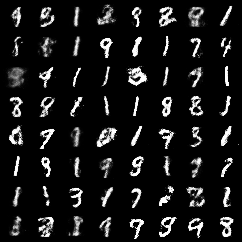



Train Epoch: 45 [0/60000 (0%)]	Loss: 58.460712
Train Epoch: 45 [12800/60000 (21%)]	Loss: 50.761491
Train Epoch: 45 [25600/60000 (43%)]	Loss: 53.878433
Train Epoch: 45 [38400/60000 (64%)]	Loss: 51.237190
Train Epoch: 45 [51200/60000 (85%)]	Loss: 70.913851
====> Epoch: 45 Average loss: 57.4870
====> Epoch: 45 Average loss: 68.2611
Sample of generated images


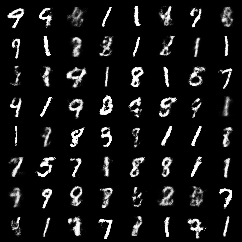



Train Epoch: 46 [0/60000 (0%)]	Loss: 51.747566
Train Epoch: 46 [12800/60000 (21%)]	Loss: 45.989460
Train Epoch: 46 [25600/60000 (43%)]	Loss: 47.595918
Train Epoch: 46 [38400/60000 (64%)]	Loss: 53.222358
Train Epoch: 46 [51200/60000 (85%)]	Loss: 45.243710
====> Epoch: 46 Average loss: 56.7928
====> Epoch: 46 Average loss: 63.1240
Sample of generated images


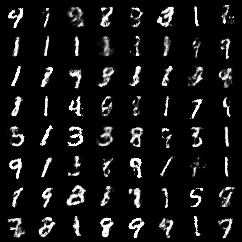



Train Epoch: 47 [0/60000 (0%)]	Loss: 50.418448
Train Epoch: 47 [12800/60000 (21%)]	Loss: 51.318550
Train Epoch: 47 [25600/60000 (43%)]	Loss: 79.119182
Train Epoch: 47 [38400/60000 (64%)]	Loss: 55.828023
Train Epoch: 47 [51200/60000 (85%)]	Loss: 57.998699
====> Epoch: 47 Average loss: 56.9864
====> Epoch: 47 Average loss: 73.3237
Sample of generated images


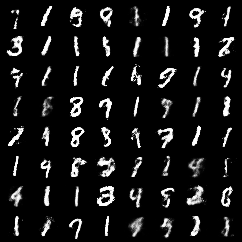



Train Epoch: 48 [0/60000 (0%)]	Loss: 48.231021
Train Epoch: 48 [12800/60000 (21%)]	Loss: 54.982960
Train Epoch: 48 [25600/60000 (43%)]	Loss: 52.969503
Train Epoch: 48 [38400/60000 (64%)]	Loss: 58.015448
Train Epoch: 48 [51200/60000 (85%)]	Loss: 64.158058
====> Epoch: 48 Average loss: 56.3190
====> Epoch: 48 Average loss: 71.5592
Sample of generated images


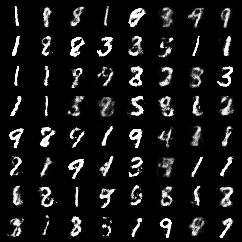



Train Epoch: 49 [0/60000 (0%)]	Loss: 55.483794
Train Epoch: 49 [12800/60000 (21%)]	Loss: 59.115469
Train Epoch: 49 [25600/60000 (43%)]	Loss: 50.070775
Train Epoch: 49 [38400/60000 (64%)]	Loss: 53.744590
Train Epoch: 49 [51200/60000 (85%)]	Loss: 59.833384
====> Epoch: 49 Average loss: 56.6818
====> Epoch: 49 Average loss: 61.2894
Sample of generated images


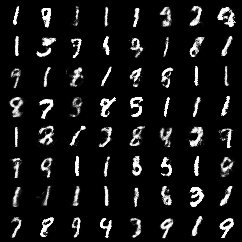



Train Epoch: 50 [0/60000 (0%)]	Loss: 53.114080
Train Epoch: 50 [12800/60000 (21%)]	Loss: 52.461129
Train Epoch: 50 [25600/60000 (43%)]	Loss: 77.554679
Train Epoch: 50 [38400/60000 (64%)]	Loss: 56.407875
Train Epoch: 50 [51200/60000 (85%)]	Loss: 52.835757
====> Epoch: 50 Average loss: 55.9207
====> Epoch: 50 Average loss: 59.9033
Sample of generated images


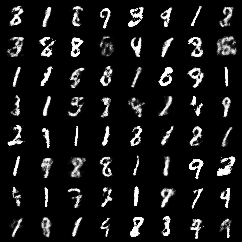

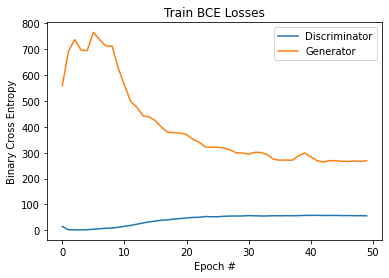

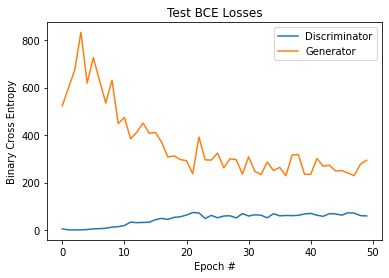

In [ ]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()
